In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import random

!rm *.csv

# 1. 	BSE:	The	Bristol	Stock	Exchange

In [ ]:
from BSE import market_session, trade_stats, populate_market, customer_orders

# 2. Experimenting	with	trading	robots

In [ ]:
def examine_trader(name):
    start_time = -30
    end_time = 60 * 3

    chart1_range=(10, 190)

    supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [chart1_range], 'stepmode': 'fixed'}]
    demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [chart1_range], 'stepmode': 'fixed'}]

    order_interval = 30
    order_sched = {
        'sup': supply_schedule,
        'dem': demand_schedule,
        'interval': order_interval,
        'timemode': 'periodic'
    }

    sellers_spec = [(name, 31)] # Name of the Trader-Robot
    buyers_spec = sellers_spec
    traders_spec = {
        'sellers':sellers_spec,
        'buyers':buyers_spec
    }

    verbose = False

    trial_id = 'smith_chart_1'
    dump_flags = {
        'dump_blotters': True,
        'dump_lobs': True,
        'dump_strats': True,
        'dump_avgbals': True,
        'dump_tape': True
    }

    random.seed(100)
    market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose=False)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot 1
    prices_fname = trial_id + '_tape.csv'
    x, y = np.loadtxt(prices_fname, delimiter=',', usecols=(1, 2), unpack=True, skiprows=1)

    ax1.plot(x, y, 'x', color='black')
    ax1.set_title(f'Transaction history for market populated by {name} traders')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price')
    ax1.set_yticks(range(0, 200 + 1, 25))
    ax1.set_xticks(np.arange(0, 180 + 1, 30))
    ax1.grid(axis='y')

    # Plot 2
    avg_balance_fname = 'smith_chart_1_avg_balance.csv'
    data = pd.read_csv(avg_balance_fname, header=None)
    time = data.iloc[:, 1].dropna().astype(float)
    avg_profit_per_trader = data.iloc[:, -2].dropna().astype(float)

    ax2.step(time, avg_profit_per_trader, where='post', color='blue')
    ax2.set_title(f'Average Profit per {name} Trader Over Time')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Average Profit per Trader')
    ax2.set_yticks(range(0, 125 + 1, 25))
    ax2.set_xticks(range(0, int(max(time)) + 1, 30))
    ax2.grid(axis='y')

    plt.tight_layout()  # Adjust layout to fit
    plt.show()


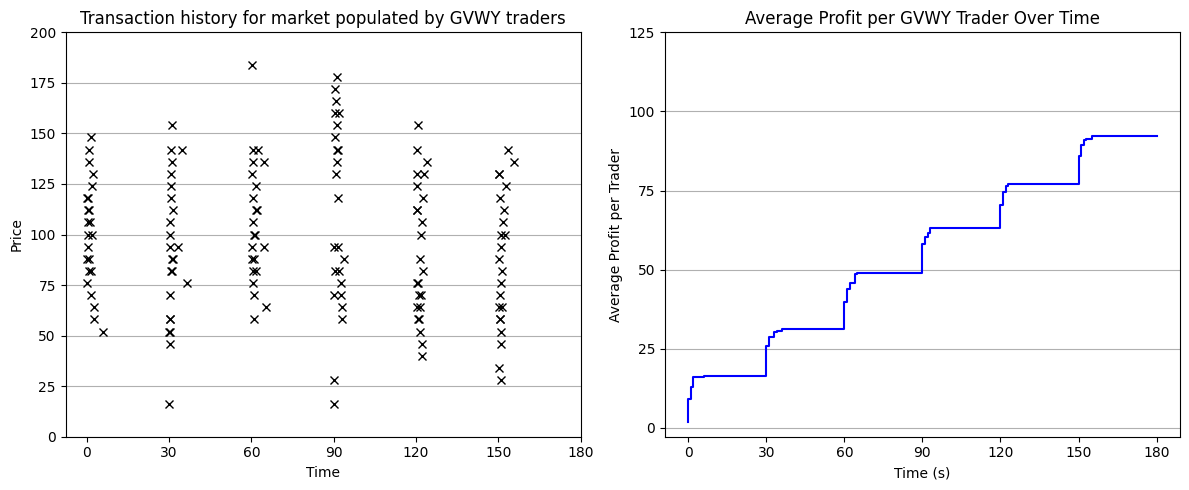

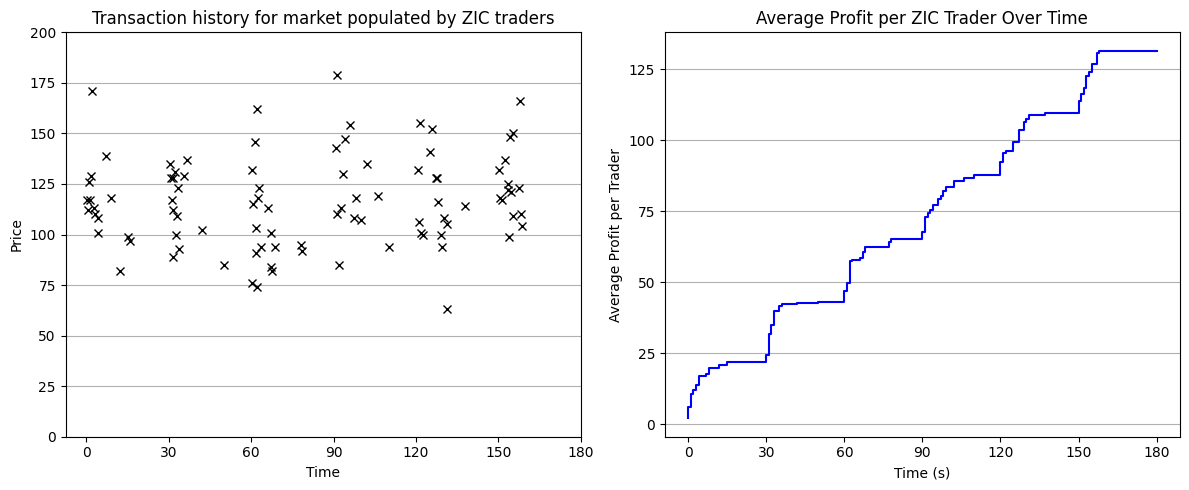

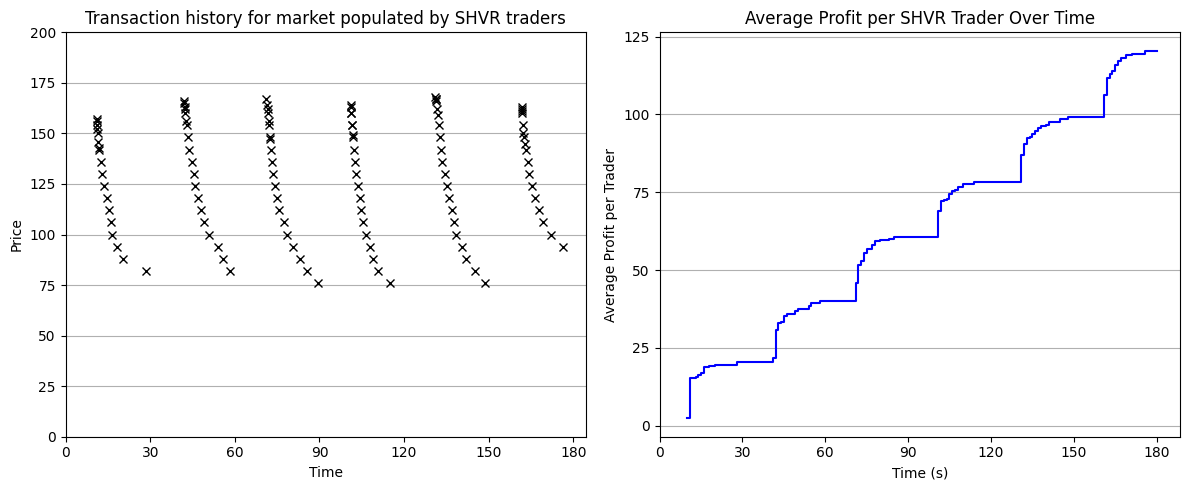

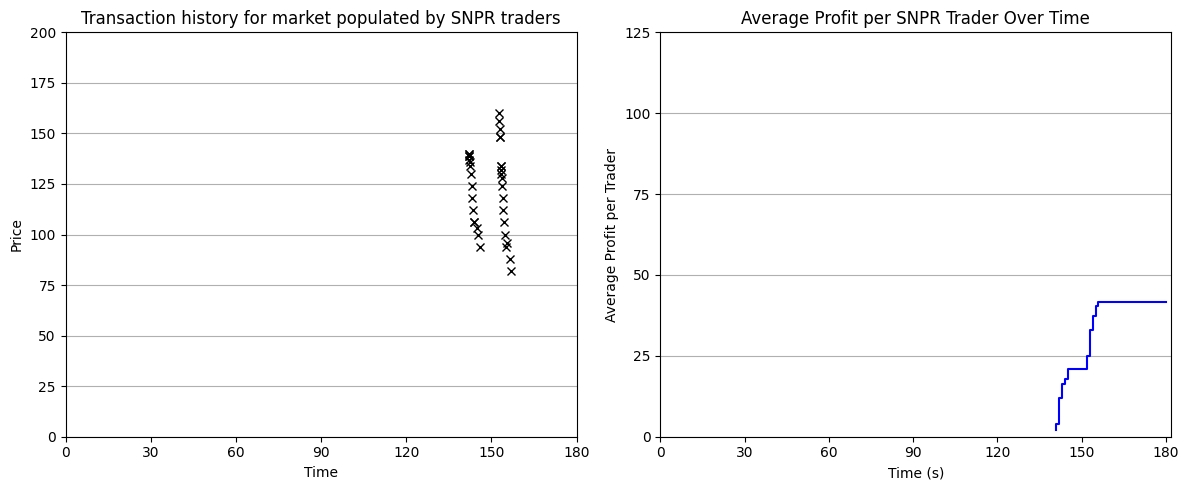

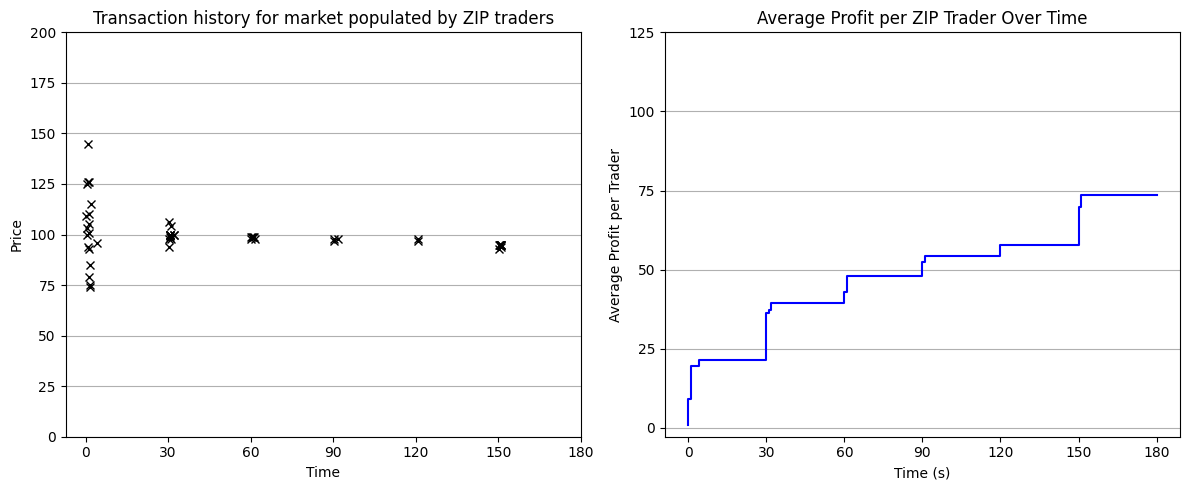

In [ ]:
traders = ['GVWY', 'ZIC', 'SHVR', 'SNPR', 'ZIP']
for trader in traders:
    examine_trader(trader)

**(LEFT) GVWY** - After each replenishment of orders, there is a quick burst of trading activity that consumes most or all of the orders in the market.
**(RIGHT) GVWY** - Average profit per Giveaway trader over 180s of trading. Horizontal axis is time; vertical axis is average profit accumulated per trader.

**(LEFT) ZIC** - Transaction history for market populated by ZIC traders, over 180s of trading.
**(RIGHT) ZIC** - Average profit per ZIC trader over 180s of trading

**(LEFT) SHVR** - Transaction history for market populated by 62 Shaver traders, over 180s of trading. Initially, there are no trades for the first c.15 seconds while each of the shaver robots repeatedly makes a minimal improvement on the best bid or offer. The best bid rises from \$0.01 to c.\$1.60 and then holds at that level, set by the highest limit price on a buy order. Meanwhile the best offer is gradually being reduced but takes longer to fall from the system maximum (an arbitrarily high value) down to \$1.60. At that point, transactions start to occur, initially at \$1.60 but then at lower prices as the higher-priced limit orders are executed. This behaviour repeats once orders are replenished.
**(RIGHT) SHVR** - Average profit per Shaver trader over 180s of trading

**(LEFT) SNPR** - There is a long period where each sniper is “lurking”, simply observing the market, and then once the time remaining until the close of the session has fallen to a low enough value, the snipers become active, generating a transaction-price time series similar to that of the “shaver” robots.
**(RIGHT) SNPR** - Average profit per Sniper trader over 180s of trading.

**(LEFT) ZIP** - Transaction history for market populated by ZIP traders, over 180s of trading. Markets populated by ZIP traders can rapidly converge on the equilibrium price (here \$1.00).
**(RIGHT) ZIP** - Average profit per ZIP trader over 180s of trading: although ZIP is good at finding the equilibrium, it makes less average profit per trader than some other simple strategies.

# 3. Altering the market supply and demand schedules in BSE

In [ ]:
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice

def make_supply_demand_plot(bids, asks, stepmode):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')

    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')

    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')

    if bids or asks:
        plt.legend()
    # plt.ylim(0,250)
    plt.grid(axis='y')
    plt.title(f'Demand Supply plot with stepmode: {stepmode}')
    plt.show()

def sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for se in range(seller_num):
        asks.append(getorderprice(se, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()

    make_supply_demand_plot(bids, asks, stepmode)

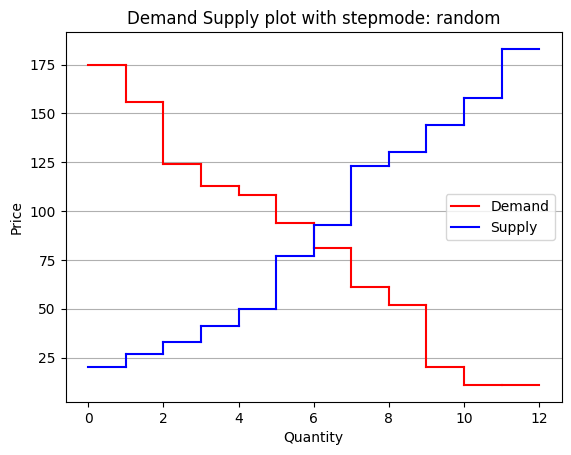

In [ ]:
start, end = 10, 190
range123 = (start, end)

sup_dem(12, [range123], 12, [range123], 'random')

The graph represents supply and demand curves generated randomly, each with 12 price points (12 buyers and 12 sellers). generated	when	both schedules	are	set	by `'ranges' : (10,190)	and 'stepmode' : 'random'`

## Other experiments with supply demand graphs

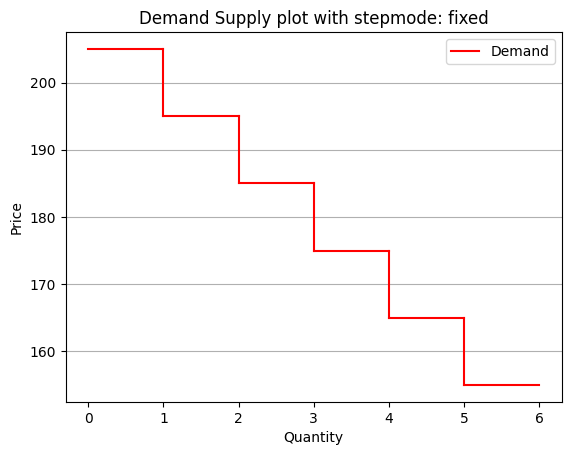

In [ ]:
# Assuming the equilibrium quantity is at 50 units
equilibrium_price = 165
equilibrium_quantity = 4

# # Setup supply range around the equilibrium price
# sup_min = equilibrium_price - 30  # Example range
# sup_max = equilibrium_price + 0
sup_ranges = [(0, 10)]

# Setup demand range around the equilibrium price
dem_min = equilibrium_price - 10  # Example range
dem_max = equilibrium_price + 40
dem_ranges = [(dem_min, dem_max)]

# Now call the function
sup_dem(0, sup_ranges, 6, dem_ranges, 'fixed')

Figure 4.1: demand curve for six buyers. Horizontal axis is quantity; vertical axis is price. See text for discussion.

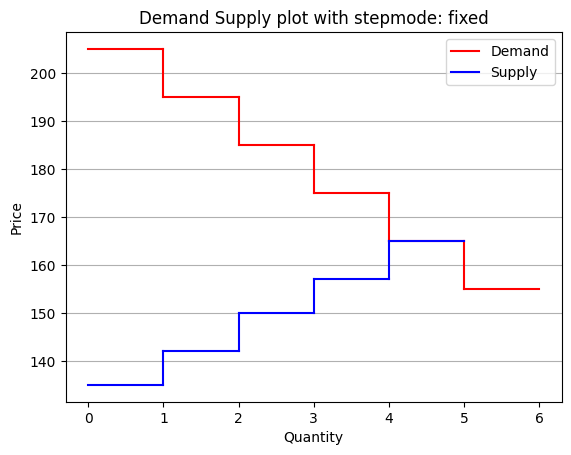

In [ ]:
# Assuming the equilibrium quantity is at 50 units
equilibrium_price = 165
equilibrium_quantity = 4

# Setup supply range around the equilibrium price
sup_min = equilibrium_price - 30  # Example range
sup_max = equilibrium_price + 0
sup_ranges = [(sup_min, sup_max)]

# Setup demand range around the equilibrium price
dem_min = equilibrium_price - 10  # Example range
dem_max = equilibrium_price + 40
dem_ranges = [(dem_min, dem_max)]

# Now call the function
sup_dem(5, sup_ranges, 6, dem_ranges, 'fixed')

Figure 4.2: adding the supply curve for five traders (in blue). The equilibrium point is given by the intersection of the supply and demand curves: the equilibrium price is $1.655 (indicated by the horizontal dashed line) and the equilibrium quantity is 4 (vertical dashed line).

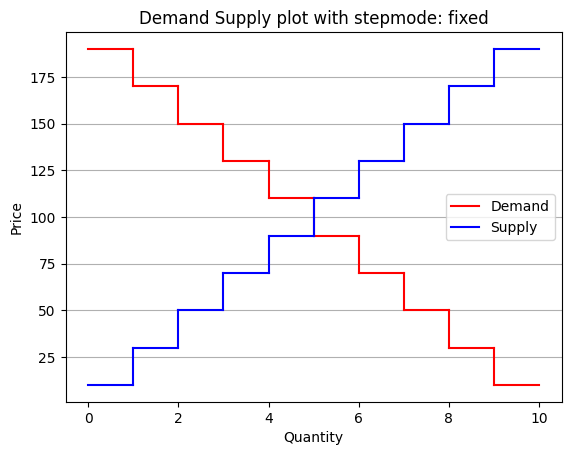

In [ ]:
sup_range = (10, 190)
dem_range = sup_range

sup_dem(10, [sup_range], 10, [dem_range], 'fixed')


Figure 4.3:supply and demand curves when both supply_schedule and demand_schedule are setby `'ranges' : [(10,190)] and 'stepmode' : 'fixed'`.

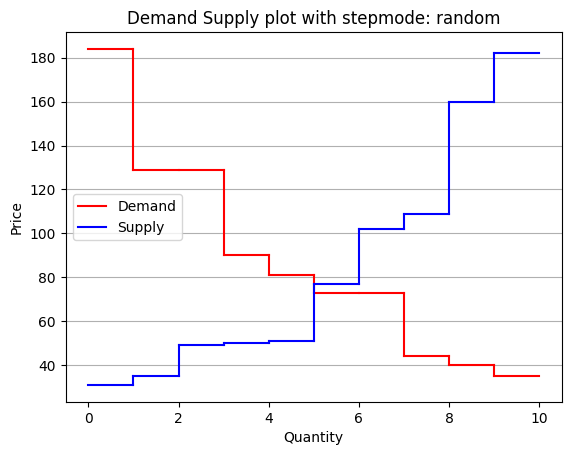

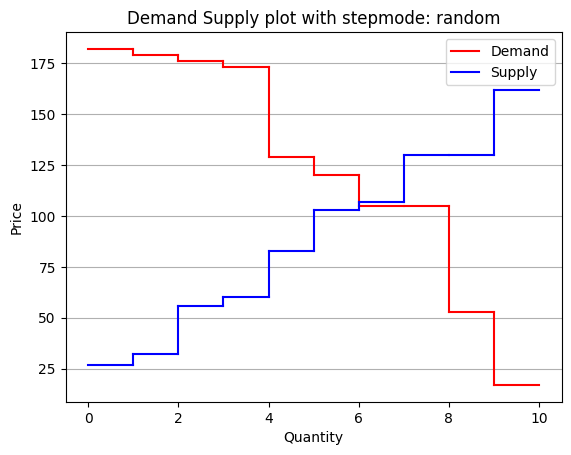

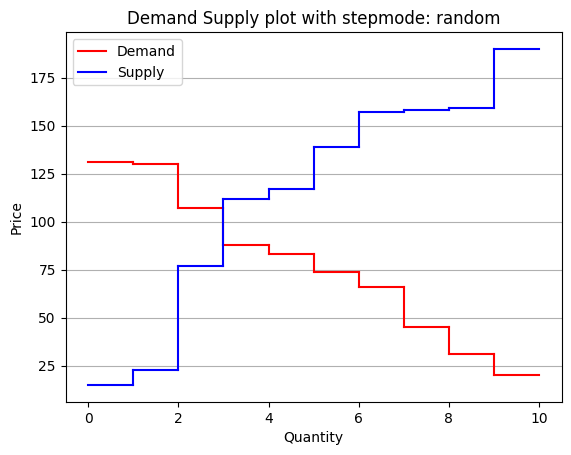

In [ ]:
sup_range = (10, 190)
dem_range = sup_range

sup_dem(10, [sup_range], 10, [dem_range], 'random')
sup_dem(10, [sup_range], 10, [dem_range], 'random')
sup_dem(10, [sup_range], 10, [dem_range], 'random')

Figure 4.4: three example supply and demand curves generated when both schedules are set by `'ranges' : [(10,190)] and 'stepmode' : 'random'`.

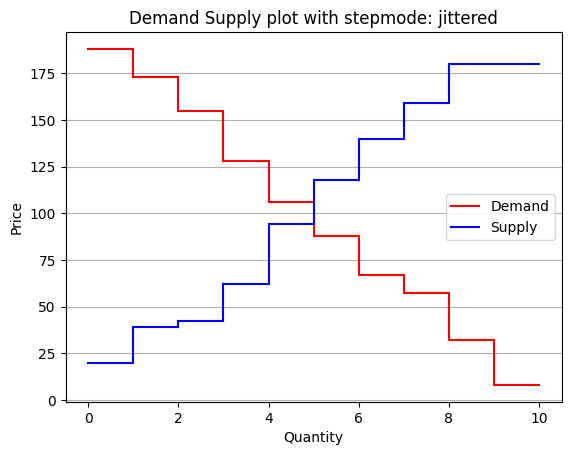

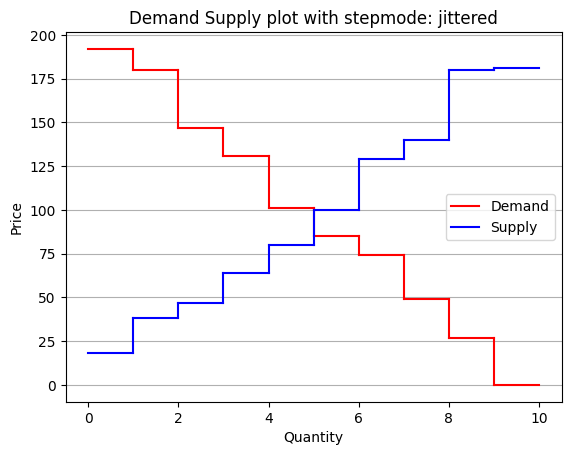

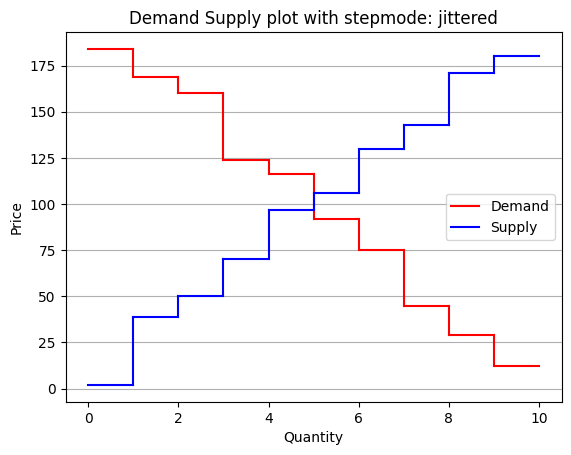

In [ ]:
# Solution:
sup_range = (10, 190)
dem_range = sup_range

sup_dem(10, [sup_range], 10, [dem_range], 'jittered')
sup_dem(10, [sup_range], 10, [dem_range], 'jittered')
sup_dem(10, [sup_range], 10, [dem_range], 'jittered')

Figure 4.5: three example supply and demand curves generated when both schedules aresetby `'ranges' : [(10,190)] and 'stepmode' : 'jitter'`.

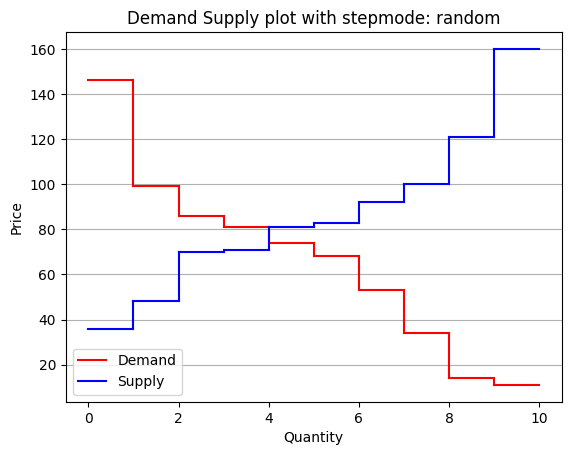

In [ ]:
# Assuming the equilibrium quantity is at 50 units
equilibrium_price = 165
equilibrium_quantity = 4

sup_ranges = [(25,50),(150,175)]
dem_ranges = [(25,50),(150,175)]

sup_dem(10, [sup_range], 10, [dem_range], 'random')


Example supply and demand curves generated when both the supply and the demand schedules are set by `'ranges' : [(25,50),(150,175)] and 'stepmode' : 'random'`.

## Transaction Price Time Series (with SHOCKS)

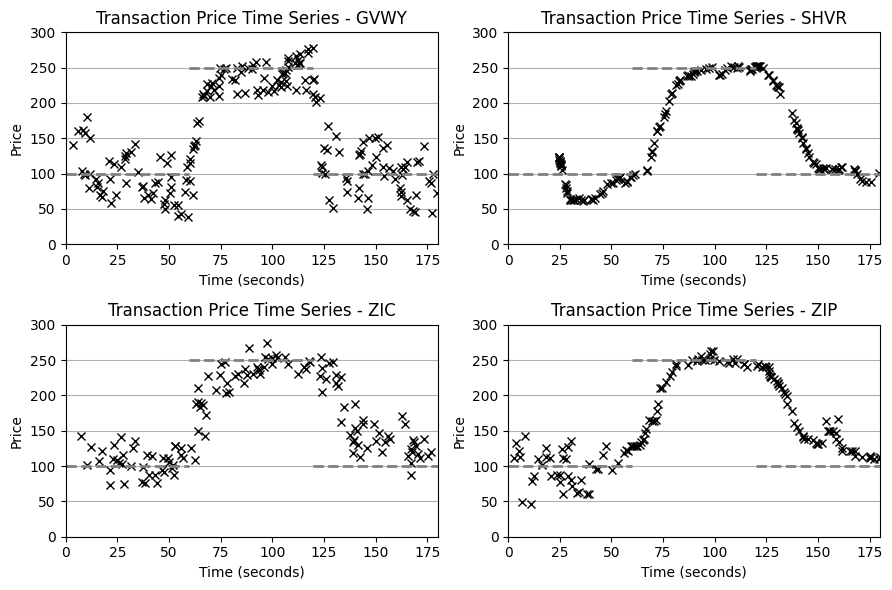

In [ ]:
# SHOCKS
range1 = (10,190) # equilibrium = (10 + 190) / 2 =  100 ($1)
range2 = (200,300) # equilibrium = (200 + 300) / 250 =  100 ($2.5)
sup_sched = [ {'from':0, 'to':60, 'ranges':[range1], 'stepmode':'random'},
             {'from':60, 'to':120, 'ranges':[range2], 'stepmode':'random'},
              {'from':120, 'to':180, 'ranges':[range1], 'stepmode':'random'}]
dem_sched = sup_sched
# SHOCKS

order_sched = {'sup':sup_sched, 'dem':dem_sched, 'interval':30, 'timemode':'drip-poisson'}
buyers_specs = [[('GVWY',40),('SHVR',0),('ZIC',0),('ZIP',0)],
              [('GVWY',0),('SHVR',40),('ZIC',0),('ZIP',0)],
              [('GVWY',0),('SHVR',0),('ZIC',40),('ZIP',0)],
              [('GVWY',0),('SHVR',0),('ZIC',0),('ZIP',40)]]

dump_flags = {
    'dumpfile': 'test1data.csv',
    'dump_avgbals': True,
    'dump_strats': True,
    'dump_lobs': True,
    'dump_blotters': True,
    'dump_tape': True,
}



fig, axs = plt.subplots(2, 2, figsize=(9, 6))
axs = axs.flatten()

# Equilibrium prices for dotted lines
equilibrium_prices = [100, 250, 100]  # From the SHOCKS block above

# Loop through each buyer spec and plot on a separate subplot
for i, buyer_spec in enumerate(buyers_specs):
    sellers_spec = buyer_spec
    traders_spec = {'sellers': sellers_spec, 'buyers': buyer_spec}
    market_session('test1', 0, 180, traders_spec, order_sched, dump_flags, False)
    prices_fname = 'test1_tape.csv'

    x = np.empty(0)
    y = np.empty(0)

    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            try:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x, time)
                y = np.append(y, price)
            except ValueError:
                continue

    axs[i].plot(x, y, 'x', color='black')  # Plot the transaction prices
    axs[i].set_title(f'Transaction Price Time Series - {buyer_spec[i][0]}')
    axs[i].set_xlabel('Time (seconds)')
    axs[i].set_ylabel('Price')
    axs[i].set_ylim(0, 300)  # Set the y-axis range from 0 to 300
    axs[i].set_xlim(0, 180)  # Set the x-axis range from 0 to 180
    axs[i].grid(axis='y')

    # Add dotted lines for equilibrium prices
    # Since we have three phases according to the shocks, we draw a line for each phase
    axs[i].axhline(y=equilibrium_prices[0], color='grey', linestyle='--', xmin=0, xmax=0.333, linewidth=2)  # First phase
    axs[i].axhline(y=equilibrium_prices[1], color='grey', linestyle='--', xmin=0.333, xmax=0.666, linewidth=2)  # Second phase
    axs[i].axhline(y=equilibrium_prices[2], color='grey', linestyle='--', xmin=0.666, xmax=1, linewidth=2)  # Third phase

# Adjust layout to fit
plt.tight_layout()
plt.show()

The graph illustrates transaction prices over time for markets with continuous order replenishment. The equilibrium price (P0) changes with "shock changes" `at 60 and 120 seconds from $1.00 to $2.50` and back. Each subplot shows the reaction of 40 buyers and 40 sellers to these price shifts, with different trader types: Giveaway, ZIC, Shaver, and ZIP.

# 4. Comparing	different	robot traders


In [ ]:
range1 = (10,190)
range2 = (200,300)
sup_sched = [ {'from':0, 'to':60, 'ranges':[range1], 'stepmode':'random'},
             {'from':60, 'to':120, 'ranges':[range2], 'stepmode':'random'},
              {'from':120, 'to':180, 'ranges':[range1], 'stepmode':'random'}]
dem_sched = sup_sched
order_sched = {'sup':sup_sched, 'dem':dem_sched, 'interval':30, 'timemode':'drip-poisson'}

buyers_spec = [('GVWY',10),('SHVR',10),('ZIC',10),('ZIP',10)]

sellers_spec = buyers_spec

traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}


dump_flags = {
    'dumpfile': 'test1data.csv',
    'dump_avgbals': True,
    'dump_strats': True,
    'dump_lobs': True,
    'dump_blotters': True,
    'dump_tape': True,
}

random.seed(100)
market_session('test1', 0, 180, traders_spec, order_sched, dump_flags, False)

## Transaction Price Time Series

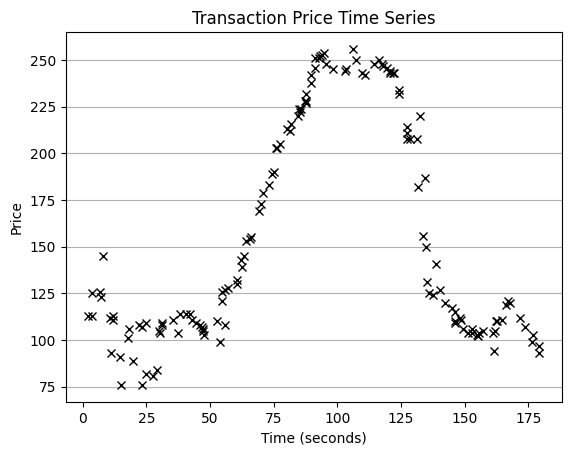

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv

prices_fname = 'test1_tape.csv'

x = np.empty(0)
y = np.empty(0)

with open(prices_fname, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        try:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x, time)
            y = np.append(y, price)
        except ValueError:
            continue

plt.plot(x, y, 'x', color='black')
plt.title('Transaction Price Time Series')
plt.xlabel('Time (seconds)')
plt.ylabel('Price')
plt.grid(axis='y')
plt.show()

Transaction-price	time-series	from	four-way	comparative	test	among	20	Giveaway,
20	Shaver,	20	ZIC,	and	20	ZIP	traders.	Horizontal	axis	is	time;	vertical	axis	is	price.

## Average Balance per Trader Type Over Time

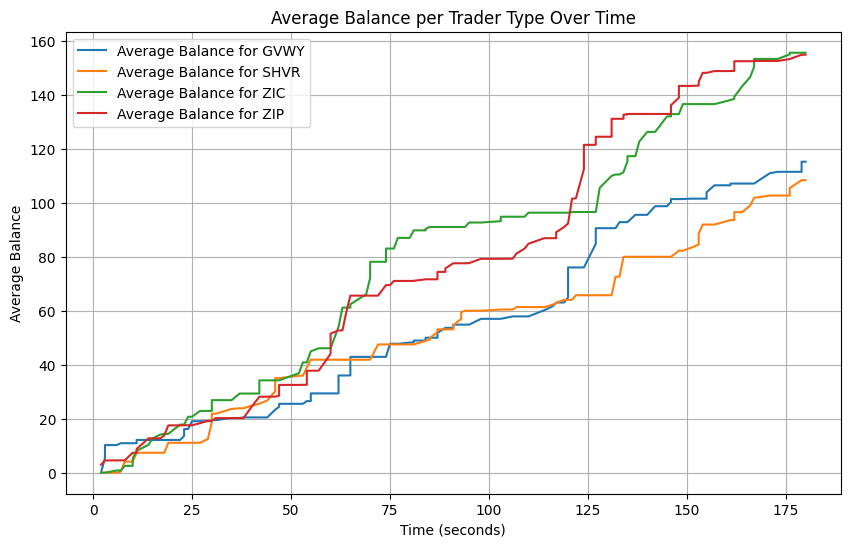

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('test1_avg_balance.csv', header=None)

time_column = 1
trader_balance_columns = {'GVWY': 7, 'SHVR': 11, 'ZIC': 15, 'ZIP': 19}  # Индексы для баланса каждого типа трейдера

plt.figure(figsize=(10, 6))

for trader, balance_col in trader_balance_columns.items():
    trader_data = data[[time_column, balance_col]].dropna()
    time = trader_data.iloc[:, 0].astype(int)
    balance = trader_data.iloc[:, 1].astype(float)

    plt.plot(time, balance, label=f'Average Balance for {trader}')

plt.title('Average Balance per Trader Type Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Balance')
plt.legend()
plt.grid(True)
plt.show()


Accumulated	average	profit	per	trader-type	in	the	five-way	comparison
experiment	whose	transaction-price	time-series	was	illustrated	in	"Transaction Price Time Series".

## 1000 Trials for constant number of traders

In [ ]:
trial	=	1
dump_flags = {
			'dump_avgbals': True,
			'dump_strats': False,
			'dump_lobs': False,
			'dump_blotters': False,
			'dump_tape': False,
}
df = pd.DataFrame()
n_trials = 1000
while	(trial < n_trials):
		market_session(f'test{trial}', 0, 180, traders_spec, order_sched, dump_flags, True)
		df1 = pd.read_csv(f'/content/test{trial}_avg_balance.csv')
		new_column_names = {df1.columns[i]: i+1 for i in range(len(df1.columns))}
		df1.rename(columns=new_column_names, inplace=True)
		df = pd.concat([df, df1]).reset_index(drop=True)
		trial	=	trial	+	1


test1;  

test2;  

test3;  

test4;  

test5;  

test6;  

test7;  

test8;  

test9;  

test10;  

test11;  

test12;  

test13;  

test14;  

test15;  

test16;  

test17;  

test18;  

test19;  

test20;  

test21;  

test22;  

test23;  

test24;  

test25;  

test26;  

test27;  

test28;  

test29;  

test30;  

test31;  

test32;  

test33;  

test34;  

test35;  

test36;  

test37;  

test38;  

test39;  

test40;  

test41;  

test42;  

test43;  

test44;  

test45;  

test46;  

test47;  

test48;  

test49;  

test50;  

test51;  

test52;  

test53;  

test54;  

test55;  

test56;  

test57;  

test58;  

test59;  

test60;  

test61;  

test62;  

test63;  

test64;  

test65;  

test66;  

test67;  

test68;  

test69;  

test70;  

test71;  

test72;  

test73;  

test74;  

test75;  

test76;  

test77;  

test78;  

test79;  

test80;  

test81;  

test82;  

test83;  

test84;  

test85;  

test86;  

test87;  

test88;  

test89;  

test90;  

test91;  

test92;

END OF TIME GVWY: 132.32497497497496
END OF TIME SHVR: 124.30630630630631
END OF TIME ZIC: 140.0048048048048
END OF TIME ZIP: 139.3585085085085


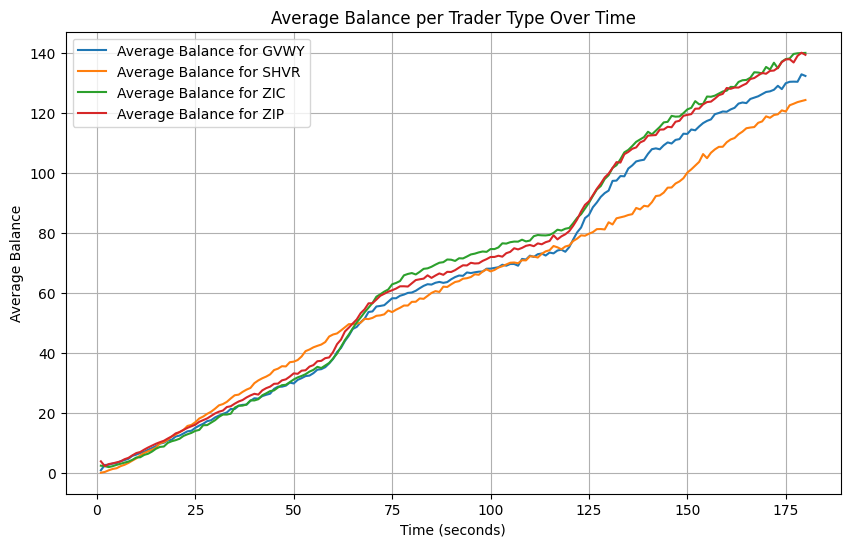

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = df

time_column = 2
trader_balance_columns = {'GVWY': 7, 'SHVR': 11, 'ZIC': 15, 'ZIP': 19}  # Индексы для баланса каждого типа трейдера

plt.figure(figsize=(10, 6))

for trader, balance_col in trader_balance_columns.items():
    trader_data = data[[time_column, balance_col + 1]].dropna()

    trader_data[time_column] = trader_data[time_column].astype(int)
    trader_data[balance_col + 1] = trader_data[balance_col + 1].astype(float)

    mean_balance = trader_data.groupby(time_column).mean()
    print(f'END OF TIME {trader}: {mean_balance.loc[180].values[0]}')
    # time = trader_data.iloc[:, 0].astype(int)
    # balance = trader_data.iloc[:, 1].astype(float)
    # print(trader_data)
    plt.plot(mean_balance.index, mean_balance[balance_col + 1], label=f'Average Balance for {trader}')

plt.title('Average Balance per Trader Type Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Balance')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!rm *.csv

## 50 trials for varying number of traders

* number of loops = 455 * n_trials_per_ratio
* got 25519 rows from n_trials_per_ratio = 1

In [ ]:
%%time
start_time = 0
end_time = 180
df = pd.DataFrame()

n_trader_types = 4
equal_ratio_n	=	4
n_trials_per_ratio = 10 # 50
n_traders = n_trader_types * equal_ratio_n

min_n, trialnumber  = 1, 1
trdr_1_n = min_n
while trdr_1_n <= n_traders:
    trdr_2_n = min_n
    while trdr_2_n <= n_traders:
        trdr_3_n = min_n
        while trdr_3_n <= n_traders - (trdr_1_n + trdr_2_n):
            trdr_4_n = n_traders - (trdr_1_n + trdr_2_n + trdr_3_n)
            if trdr_4_n >= min_n:
                buyers_spec = [
                    ('GVWY', trdr_1_n),
                    ('SHVR', trdr_2_n),
                    ('ZIC', trdr_3_n),
                    ('ZIP', trdr_4_n)
                ]
                sellers_spec = buyers_spec
                traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}
                # print(buyers_spec)
                trial = 1
                while trial <= n_trials_per_ratio:
                    market_session(f'test{trial}', start_time, end_time, traders_spec, order_sched, dump_flags, False)
                    df1 = pd.read_csv(f'/content/test{trial}_avg_balance.csv')
                    new_column_names = {df1.columns[i]: i+1 for i in range(len(df1.columns))}
                    df1.rename(columns=new_column_names, inplace=True)
                    df = pd.concat([df, df1]).reset_index(drop=True)
                    trial = trial + 1
                    trialnumber = trialnumber + 1
                    print(trialnumber)
            trdr_3_n += 1
        trdr_2_n += 1
    trdr_1_n += 1

In [ ]:
print(f'number of trials = {trialnumber - 1}')
df.shape

number of trials = 4550


(255281, 21)

END OF TIME GVWY: 125.75353525582418
END OF TIME SHVR: 112.81752377428572
END OF TIME ZIC: 141.109712001978
END OF TIME ZIP: 135.5746791854945


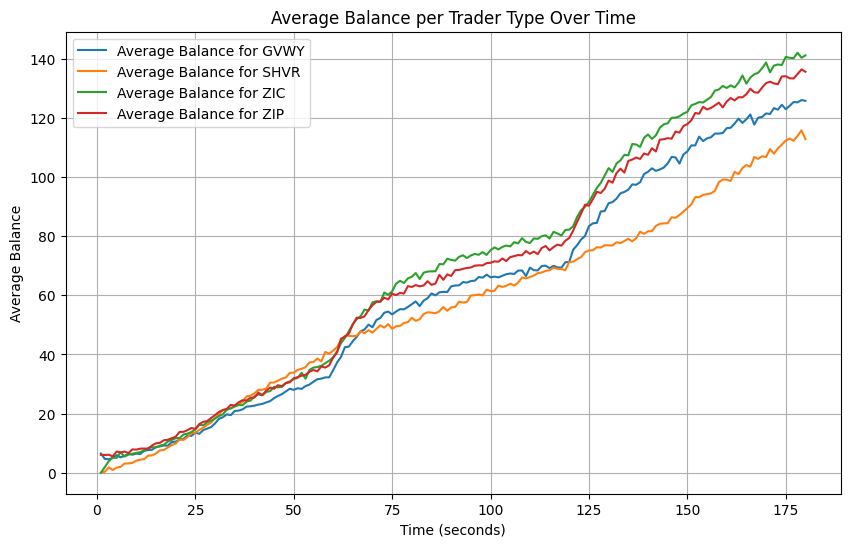

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = df

time_column = 2
trader_balance_columns = {'GVWY': 7, 'SHVR': 11, 'ZIC': 15, 'ZIP': 19}  # Индексы для баланса каждого типа трейдера

plt.figure(figsize=(10, 6))

for trader, balance_col in trader_balance_columns.items():
    trader_data = data[[time_column, balance_col + 1]].dropna()

    trader_data[time_column] = trader_data[time_column].astype(int)
    trader_data[balance_col + 1] = trader_data[balance_col + 1].astype(float)

    mean_balance = trader_data.groupby(time_column).mean()
    print(f'END OF TIME {trader}: {mean_balance.loc[180].values[0]}')
    # time = trader_data.iloc[:, 0].astype(int)
    # balance = trader_data.iloc[:, 1].astype(float)
    # print(trader_data)
    plt.plot(mean_balance.index, mean_balance[balance_col + 1], label=f'Average Balance for {trader}')

plt.title('Average Balance per Trader Type Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Balance')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!rm *.csv